In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.base.datetools import dates_from_str
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tsa.stattools import adfuller
import os

# VAR (Vector Autoregressive) Model and IRF (Impulse Response Function) Analysis
The main purpose of this notebook will be to take our existing panel dataset and transform it into data for a vector autoregressive model, which models how variables influence one another, including throughout time, modelling how past values, or lags influence current and future outcomes.

Additionally, impulse response functions model how shocks to a single factor in the model influence the other factors in the model.

In [3]:
data_dir = './india_panel/'

daily_panel_df = pd.read_csv(os.path.join(data_dir, 'panel_daily_070824.csv'))

In [4]:
daily_panel_df.describe()

,pct_blackout,avg_duration,freq,t2m_k,d2m,sp,wind,sh,rh,e,tp,station_id,lat,lon
count,296176.000000,296176.000000,296176.000000,296176.000000,296176.000000,296176.000000,296176.000000,296176.000000,296176.000000,296176.000000,2.961760e+05,296176.000000,296176.000000,296176.000000
mean,0.101779,34.857789,2.581023,298.300166,289.854462,96893.341720,2.414599,0.054802,25.612348,-0.001504,3.186240e+00,305.769488,21.871017,78.662424
std,0.185605,87.195088,3.702002,4.989238,6.231162,3430.934082,1.071801,0.014767,3.901077,0.000844,8.693994e+00,171.626253,5.191600,4.477703
min,0.000000,0.000000,0.000000,259.002731,247.392294,68078.696049,0.174413,0.005227,7.148449,-0.005126,-2.775558e-14,1.000000,11.386231,72.765044
25%,0.000000,0.000000,0.000000,295.609264,284.893150,94749.080896,1.636030,0.045996,23.505564,-0.002188,2.775558e-14,159.000000,17.956816,74.774083
50%,0.009722,6.500000,1.000000,298.721973,290.750542,97530.328721,2.210990,0.054039,25.746057,-0.001324,4.433472e-02,310.000000,21.132589,77.599407
75%,0.109722,35.384615,4.000000,301.437001,295.104299,99508.505828,2.966696,0.062765,27.943858,-0.000793,2.084841e+00,466.000000,26.699914,80.944505
max,1.000000,1436.000000,153.000000,312.092763,300.720980,101883.897532,9.936679,0.113009,37.973481,-0.000034,2.528902e+02,571.000000,30.747120,94.203708


In [5]:
date_string = dates_from_str(daily_panel_df['date'])

In [6]:
daily_panel_df.index = pd.DatetimeIndex(date_string)

We have previously determined that the only weather factors of interest to us are the the total precipitation, wind speed, and temperature, so we'll subset out that data, along with the voltage factors.

In [7]:
daily_panel_model_data = daily_panel_df.drop(['date', 'location', 'state', 'district', 'lat', 'lon', 'station_id'], axis=1)
daily_panel_model_data = daily_panel_model_data[['pct_blackout', 'avg_duration', 'freq', 't2m_k', 'wind', 'tp']]

In [8]:
var_model = VAR(daily_panel_model_data)

c:\Users\nytig\miniconda3\envs\res_energy_net\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nytig\miniconda3\envs\res_energy_net\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


## Determining Stationarity and Multicollinearity
Before we create our VAR and IRF models, we have to determine whether or not the data is fit for this analysis. Two of the main requirements are that all the time series are stationary, and that we remove any co-linear and multi-colinear variables.

### Stationarity
In order to determine stationarity, we will use ADF.

In [8]:
for col in daily_panel_model_data.columns:
    print(f'ADF test for {col}: {adfuller(daily_panel_model_data[col], maxlag=10)}')

ADF test for pct_blackout: (-20.020075957170516, 0.0, 89, 296086, {'1%': -3.4303720860043834, '5%': -2.861549761739158, '10%': -2.566775195819752}, -504918.5460513674)
ADF test for avg_duration: (-23.368309343556408, 0.0, 89, 296086, {'1%': -3.4303720860043834, '5%': -2.861549761739158, '10%': -2.566775195819752}, 3408382.65080267)
ADF test for freq: (-22.42955198333674, 0.0, 84, 296091, {'1%': -3.4303720856314204, '5%': -2.861549761574314, '10%': -2.5667751957320113}, 1333704.1404855298)
ADF test for t2m_k: (-49.179315840239454, 0.0, 88, 296087, {'1%': -3.4303720859297897, '5%': -2.861549761706189, '10%': -2.5667751958022036}, 809556.5482318938)
ADF test for wind: (-42.3643614783473, 0.0, 89, 296086, {'1%': -3.4303720860043834, '5%': -2.861549761739158, '10%': -2.566775195819752}, 483467.31387937354)
ADF test for tp: (-50.6038813688608, 0.0, 89, 296086, {'1%': -3.4303720860043834, '5%': -2.861549761739158, '10%': -2.566775195819752}, 1972595.336561259)


We can see that all of these pass with a low p-value, so we can say that all of these variables are stationary.

### Co-Linearity

In [9]:
daily_panel_model_data.corr()

,pct_blackout,avg_duration,freq,t2m_k,wind,tp
pct_blackout,1.000000,0.609480,0.472530,0.019541,-0.018213,0.036213
avg_duration,0.609480,1.000000,0.110239,-0.014088,-0.023247,0.004787
freq,0.472530,0.110239,1.000000,0.061543,0.008568,0.056098
t2m_k,0.019541,-0.014088,0.061543,1.000000,0.206445,0.008998
wind,-0.018213,-0.023247,0.008568,0.206445,1.000000,0.088882
tp,0.036213,0.004787,0.056098,0.008998,0.088882,1.000000


We can see that there are no simple co-linearities in the data. We now use VIF to determine if there are any multi-collinearities in the data.

In [10]:
# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = daily_panel_model_data.columns
  
# calculating VIF for ea|ch feature 
vif_data["VIF"] = [vif(daily_panel_model_data.values, i) 
                          for i in range(len(daily_panel_model_data.columns))]

vif_data 

,feature,VIF
0,pct_blackout,2.815366
1,avg_duration,1.973104
2,freq,2.050888
3,t2m_k,6.804908
4,wind,6.215808
5,tp,1.147137


We have two VIF values between 5 and 10, indicating a moderate correlation between those factors and the others in the dataset, however, because of the nature of the variables we're dealing with, namely weather, this is not unexpected, and we will keep this remaining dataset and move forward.

## Deciding the Lag
Before fitting our model, we have to decide the appropriate lag to use. In this case we will use the Bayesian Information Criterion or BIC.

In [11]:
min_bic = np.inf
min_lag = 0

bics = []
lags = []
for i in range(20):
    results = var_model.fit(i)
    if results.bic < min_bic:
        min_bic = results.bic
        min_lag = i

    bics.append(results.bic)
    lags.append(i)

Minimum BIC:  7.885380130046748 Corresponding Lag:  19


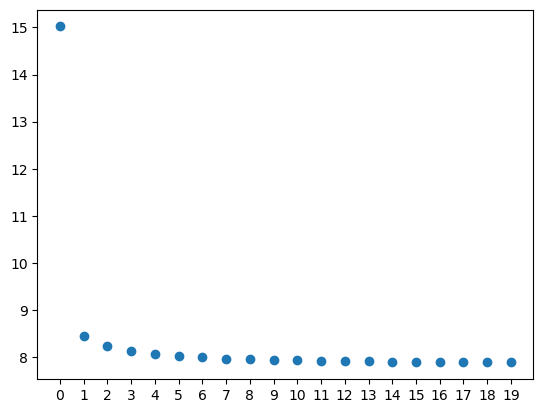

In [12]:
print('Minimum BIC: ', min_bic, 'Corresponding Lag: ', min_lag)

fig, ax = plt.subplots()
ax.xaxis.set_ticks(np.arange(0, 20, 1))
plt.scatter(lags, bics)

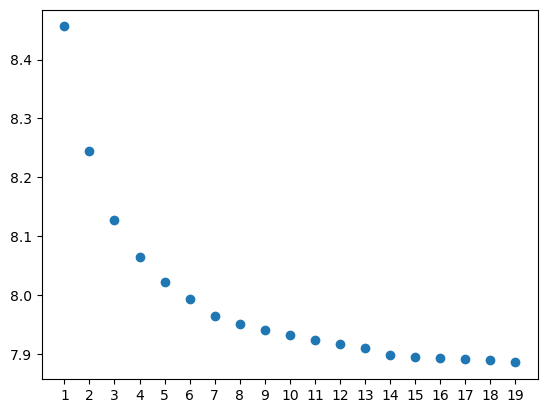

In [13]:
lags2 = lags[1:]
bics2 = bics[1:]

fig, ax = plt.subplots()
ax.xaxis.set_ticks(np.arange(1, 20, 1))
plt.scatter(lags2, bics2)

In [9]:
results = var_model.fit(4)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 17, Jul, 2024
Time:                     10:08:37
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    8.06391
Nobs:                     296172.    HQIC:                   8.06009
Log likelihood:      -3.71471e+06    FPE:                    3160.67
AIC:                      8.05854    Det(Omega_mle):         3159.07
--------------------------------------------------------------------
Results for equation pct_blackout
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   0.003975         0.011821            0.336           0.737
L1.pct_blackout         0.649561         0.002119          306.539           0.000
L1.avg_duration        -0.000337         0.00

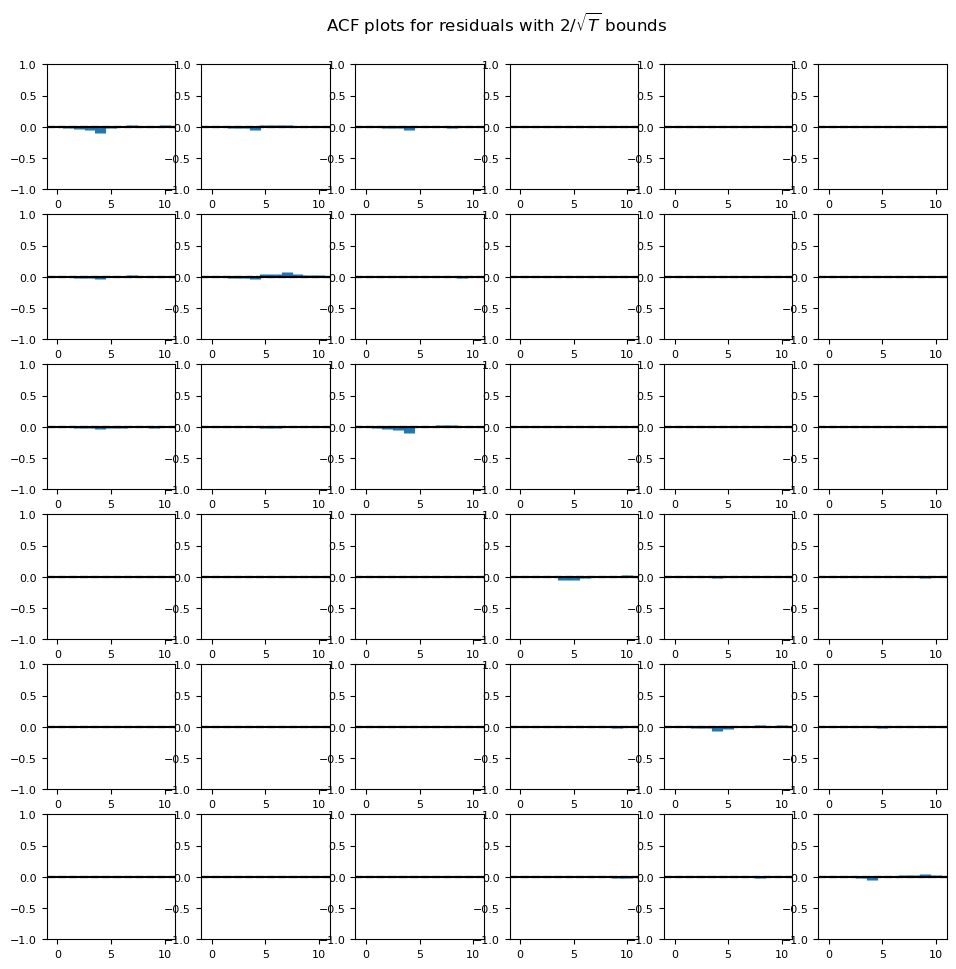

In [13]:
ax = results.plot_acorr()

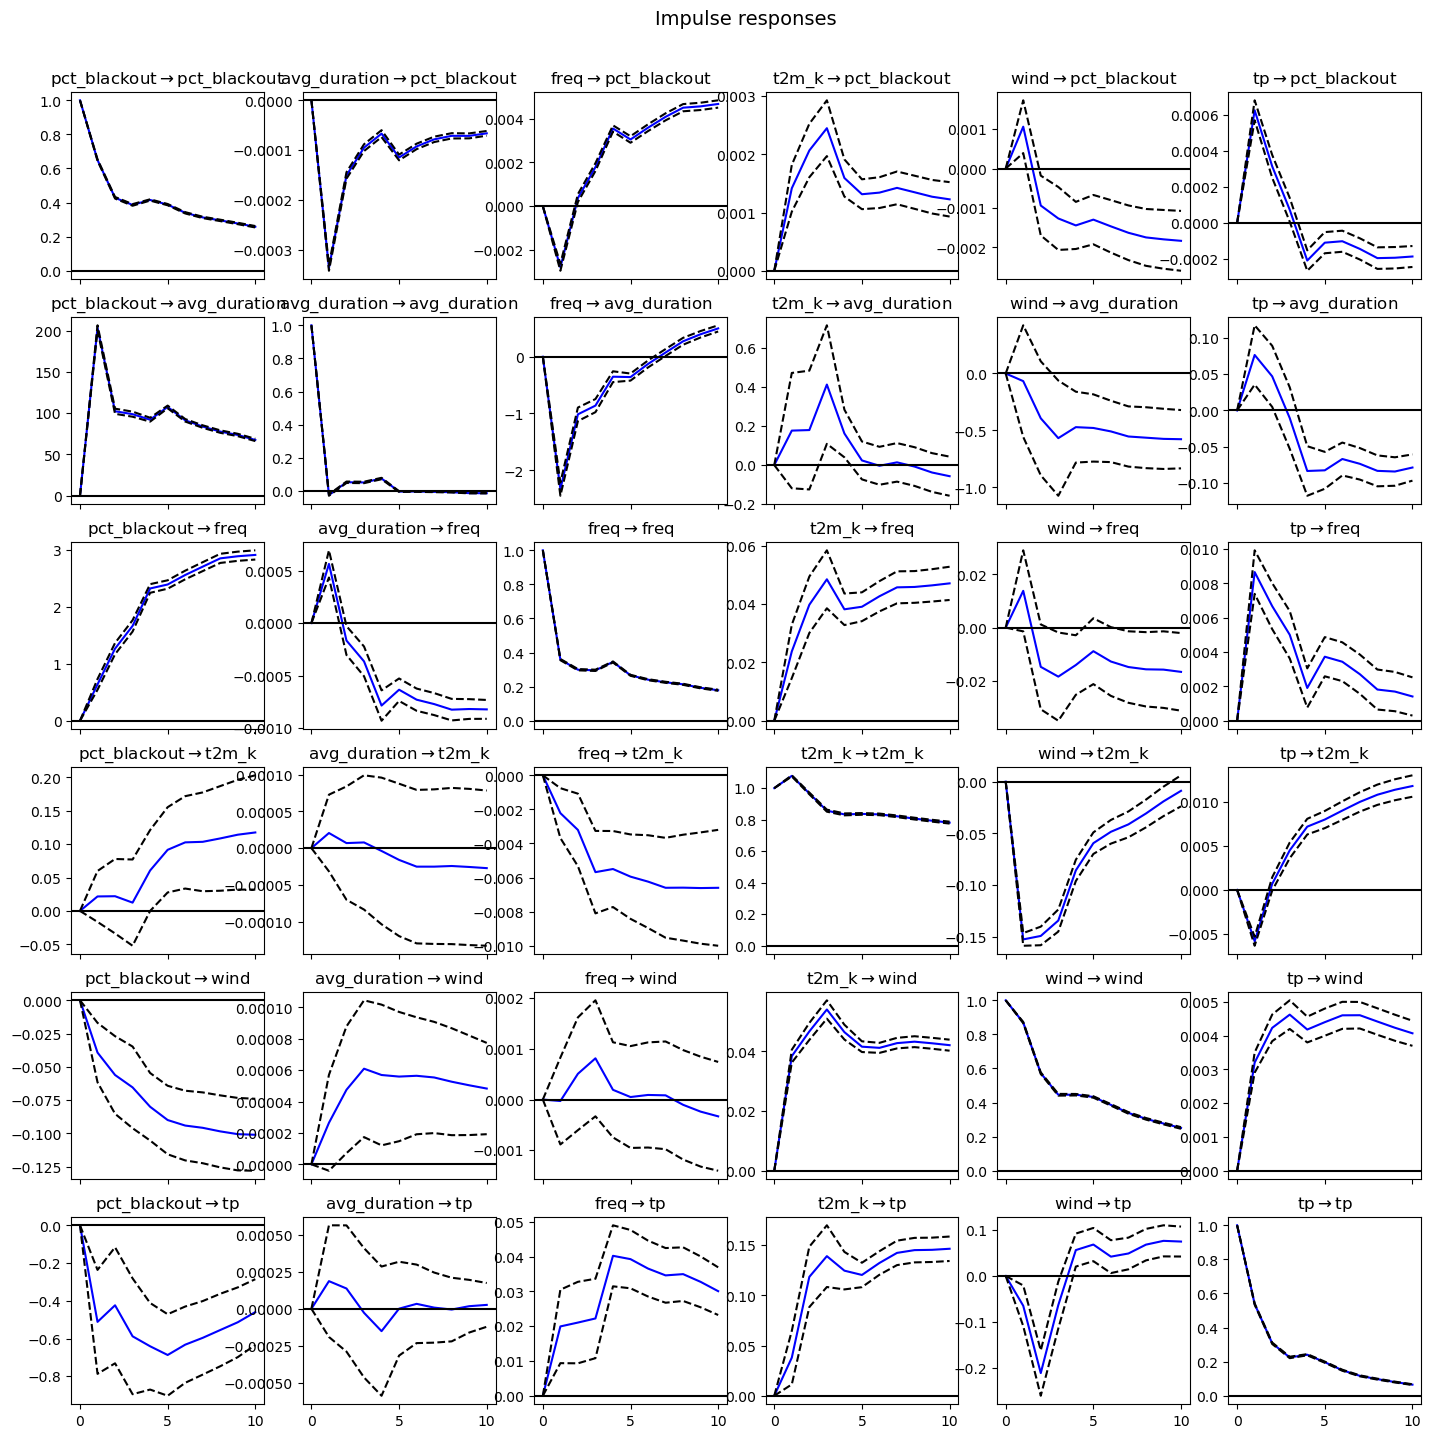

In [16]:
irf = results.irf(10)
ax = irf.plot(orth=False, figsize=(15, 15))

# Hourly Dataset
Now we repeat the process with the hourly dataset.

In [19]:
hourly_panel_df = pd.read_csv(os.path.join(data_dir, 'panel_hourly_070824.csv'), index_col=False)

In [22]:
hourly_panel_df.describe()

,pct_blackout,t2m_k,d2m,wind,tp,e,sp,sh,rh,station_id,lat,lon
count,7.193411e+06,7.193411e+06,7.193411e+06,7.193411e+06,7.193411e+06,7.193411e+06,7.193411e+06,7.193411e+06,7.193411e+06,7.193411e+06,7.193411e+06,7.193411e+06
mean,1.023334e-01,2.982986e+02,2.898552e+02,2.413820e+00,1.331183e-01,-1.503973e-03,9.688755e+04,5.479757e-02,2.561161e+01,3.052045e+02,2.186711e+01,7.866115e+01
std,2.745645e-01,6.236792e+00,6.417294e+00,1.312250e+00,5.616856e-01,1.221071e-03,3.435359e+03,1.920670e-02,4.970405e+00,1.714024e+02,5.186244e+00,4.476872e+00
min,0.000000e+00,2.502431e+02,2.389706e+02,4.329809e-04,-2.645470e+00,-8.465774e-03,6.793847e+04,2.273867e-03,4.963018e+00,1.000000e+00,1.138623e+01,7.276504e+01
25%,0.000000e+00,2.947998e+02,2.848176e+02,1.482970e+00,0.000000e+00,-2.364229e-03,9.474720e+04,4.278045e-02,2.270405e+01,1.590000e+02,1.808430e+01,7.477408e+01
50%,0.000000e+00,2.986108e+02,2.909743e+02,2.209970e+00,0.000000e+00,-1.207947e-03,9.752376e+04,5.274948e-02,2.553699e+01,3.090000e+02,2.113259e+01,7.759941e+01
75%,0.000000e+00,3.021225e+02,2.952095e+02,3.104316e+00,1.597519e-02,-5.035434e-04,9.949989e+04,6.441971e-02,2.850956e+01,4.650000e+02,2.665998e+01,8.094450e+01
max,1.000000e+00,3.195340e+02,3.024138e+02,1.643662e+01,3.207439e+01,4.337072e-05,1.021332e+05,1.626527e-01,4.553516e+01,5.710000e+02,3.074712e+01,9.420371e+01


In [23]:
hourly_date_string = dates_from_str(hourly_panel_df['datetime'])

In [24]:
hourly_panel_df.index = pd.DatetimeIndex(hourly_date_string)

In [29]:
hourly_panel_model_data = hourly_panel_df.drop(['datetime', 'location', 'state', 'district', 'lat', 'lon', 'station_id'], axis=1)
hourly_panel_model_data = hourly_panel_model_data[['pct_blackout', 't2m_k', 'wind', 'tp']]

In [30]:
var_model_h = VAR(hourly_panel_model_data)

c:\Users\nytig\miniconda3\envs\res_energy_net\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nytig\miniconda3\envs\res_energy_net\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [31]:
for col in hourly_panel_model_data.columns:
    print(f'ADF test for {col}: {adfuller(hourly_panel_model_data[col], maxlag=10)}')

MemoryError: Unable to allocate 1.50 GiB for an array with shape (28, 7193213) and data type float64

In [32]:
hourly_panel_model_data.corr()

,pct_blackout,t2m_k,wind,tp
pct_blackout,1.000000,0.048149,0.000854,0.019695
t2m_k,0.048149,1.000000,0.224419,0.003742
wind,0.000854,0.224419,1.000000,0.063848
tp,0.019695,0.003742,0.063848,1.000000


In [33]:
# VIF dataframe 
vif_data_h = pd.DataFrame() 
vif_data_h["feature"] = hourly_panel_model_data.columns
  
# calculating VIF for ea|ch feature 
vif_data_h["VIF"] = [vif(hourly_panel_model_data.values, i) 
                          for i in range(len(hourly_panel_model_data.columns))]

vif_data_h 

,feature,VIF
0,pct_blackout,1.0
1,t2m_k,1.0
2,wind,1.0
3,tp,1.0


In [34]:
min_bic_h = np.inf
min_lag_h = 0

bics_h = []
lags_h = []
for i in range(20):
    results_h = var_model_h.fit(i)
    if results_h.bic < min_bic_h:
        min_bic_h = results_h.bic
        min_lag_h = i

    bics_h.append(results.bic)
    lags_h.append(i)

In [ ]:
print('Minimum BIC: ', min_bic_h, 'Corresponding Lag: ', min_lag_h)

fig, ax = plt.subplots()
ax.xaxis.set_ticks(np.arange(0, 20, 1))
plt.scatter(lags_h, bics_h)

In [ ]:
lags_h2 = lags_h[1:]
bics_h2 = bics_h[1:]

fig, ax = plt.subplots()
ax.xaxis.set_ticks(np.arange(1, 20, 1))
plt.scatter(lags_h2, bics_h2)

In [ ]:
results_h = var_model.fit(4)
results_h.summary()

In [ ]:
results_h.plot_acorr()

In [ ]:
irf_h = results_h.irf(10)
irf_h.plot(orth=False)